In [4]:
import h5py
import numpy as np
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

# f = h5py.File('../dummy_data/jax_test/inputdata.h5', "r")
f = h5py.File('inputdata.h5', "r")

print(f.keys())

pnames = [str(p) for p in f.get('params').attrs["names"]]
print("parameter names: ", pnames)

observables = np.unique([x.decode().split("#")[0] for x in f.get("index")[:]])
print(len(observables), " observables")
print(observables[1:10])
print(f.get("index")[1:10])

index = {}
II = [x.decode() for x in f.get("index")[:]]
[index.setdefault(bin.split('#')[0], []).append(i) for i,bin in enumerate(II)]
index = {k : np.array(index[k]) for k in index.keys()}

<KeysViewHDF5 ['errors', 'index', 'params', 'runs', 'values', 'xmax', 'xmin']>
parameter names:  ['MPIalphaS']
4725  observables
['/ATLAS_2019_I1736531/d01-x01-y01[AUX_isr:murfac=0.5]'
 '/ATLAS_2019_I1736531/d01-x01-y01[AUX_isr:murfac=2.0]'
 '/ATLAS_2019_I1736531/d01-x01-y01[AUX_isr:pdf:minus=1.0]'
 '/ATLAS_2019_I1736531/d01-x01-y01[AUX_isr:pdf:plus=1.0]'
 '/ATLAS_2019_I1736531/d01-x01-y01[AUX_mur0.5_muf1]'
 '/ATLAS_2019_I1736531/d01-x01-y01[AUX_mur2_muf_1]'
 '/ATLAS_2019_I1736531/d01-x01-y01[AUX_pdfdn]'
 '/ATLAS_2019_I1736531/d01-x01-y01[AUX_pdfup]'
 '/ATLAS_2019_I1736531/d02-x01-y01']
[b'/ATLAS_2019_I1736531/d01-x01-y01#1'
 b'/ATLAS_2019_I1736531/d01-x01-y01#2'
 b'/ATLAS_2019_I1736531/d01-x01-y01#3'
 b'/ATLAS_2019_I1736531/d01-x01-y01#4'
 b'/ATLAS_2019_I1736531/d01-x01-y01#5'
 b'/ATLAS_2019_I1736531/d01-x01-y01#6'
 b'/ATLAS_2019_I1736531/d01-x01-y01#7'
 b'/ATLAS_2019_I1736531/d01-x01-y01[AUX_isr:murfac=0.5]#0'
 b'/ATLAS_2019_I1736531/d01-x01-y01[AUX_isr:murfac=0.5]#1']


In [5]:
def numCoeffsPoly(dim, order):
    """
    Number of coefficients a dim-dimensional polynomial of order order has.
    """
    ntok = 1
    r = min(order, dim)
    for i in range(r):
        ntok = ntok * (dim + order - i) / (i + 1)
    return int(ntok)
def mono_next_grlex(m, x):
    #  Author:
    #
    #    John Burkardt
    #
    #     TODO --- figure out the licensing thing https://people.sc.fsu.edu/~jburkardt/py_src/monomial/monomial.html

    #  Find I, the index of the rightmost nonzero entry of X.
    i = 0
    for j in range(m, 0, -1):
        if 0 < x[j-1]:
            i = j
            break

    #  set T = X(I)
    #  set X(I) to zero,
    #  increase X(I-1) by 1,
    #  increment X(M) by T-1.
    if i == 0:
        x[m-1] = 1
        return x
    elif i == 1:
        t = x[0] + 1
        im1 = m
    elif 1 < i:
        t = x[i-1]
        im1 = i - 1

    x[i-1] = 0
    x[im1-1] = x[im1-1] + 1
    x[m-1] = x[m-1] + t - 1

    return x

def vandermonde_jax(params, order):
    """
    Construct the Vandermonde matrix.
    """
    try:
        dim = len(params[0])
    except:
        dim = 1

    #We will take params to the power of s element-wise
    if dim == 1:
        s = jnp.array(range(order+1))
    else:
        term_list = [[0]*dim]
        for i in range(1, numCoeffsPoly(dim, order)):
            term_list.append(mono_next_grlex(dim, term_list[-1][:]))
        s = jnp.array(term_list)
    
    if len(params[0]) == 1:
        V = jnp.zeros((len(params), numCoeffsPoly(dim, order)), dtype=jnp.float64)
        for a, p in enumerate(params): 
            V = V.at[a].set(p**s)
        return V
    else:
        V = jnp.power(params, s[:, jnp.newaxis])
        return jnp.prod(V, axis=2).T


In [6]:
order = 3
dim = len(f['params'][0])
bin_name = '/ATLAS_2019_I1736531/d01-x01-y01[AUX_isr:murfac=0.5]#0'
# bin_name = "/func0#0"

obs_name, bin_number = bin_name.split('#')[0], bin_name.split('#')[1] 
X = np.array(f['params'][:], dtype=np.float64)
Y = f['values'][index[obs_name][int(bin_number)]]

VM = vandermonde_jax(X, order)
print('should be 0(equal): ', np.subtract(vandermonde_jax(X, order),VM))
print('params ', X)
print('values ', Y)
print('vandermonde ', VM)

NameError: name 'vandermonde' is not defined

In [ ]:
print(f.keys())
print(list(f['runs']))

<KeysViewHDF5 ['errors', 'index', 'params', 'runs', 'values', 'xmax', 'xmin']>
[b'submit/000000', b'submit/000001', b'submit/000002', b'submit/000003', b'submit/000004', b'submit/000005', b'submit/000006', b'submit/000007', b'submit/000008', b'submit/000009']


In [ ]:
def grlex_eval(dim, order, coeff, x):
    np.flip(x)
    term = np.zeros(dim)
    sum = 0
    for i in range(numCoeffsPoly(dim, order)):
        sum += coeff[i]*(x**term).prod()
        # print(coeff[i], ' * ', x**term, ' term ', term)
        term = mono_next_grlex(dim, term)
    return sum.sum()

[  -12.17221249   331.0869855  -3059.79276365  9989.71780183]


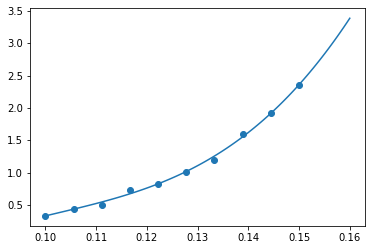

In [ ]:
pceoff, res, rank, s  = np.linalg.lstsq(VM, Y, rcond=None)
print(pceoff)
# xmin = f['xmin'][index[obs_name][int(bin_number)]]

x = np.linspace(0.1,0.16,100)
surrogate = [grlex_eval(dim, order, pceoff, i) for i in x]
surrogate2 = np.matmul(VM,x)
plt.plot(x, surrogate)
plt.scatter(X.flatten(), Y)
print(surrogate, surrogate2)

In [ ]:
f.close()

In [ ]:
import numpy as np
from numba import jit, njit

# @njit
def mono_next_grlex(m, x):
    #  Author:
    #
    #    John Burkardt
    #
    #     TODO --- figure out the licensing thing https://people.sc.fsu.edu/~jburkardt/py_src/monomial/monomial.html

    #  Find I, the index of the rightmost nonzero entry of X.
    i = 0
    for j in range(m, 0, -1):
        if 0 < x[j-1]:
            i = j
            break

    #  set T = X(I)
    #  set X(I) to zero,
    #  increase X(I-1) by 1,
    #  increment X(M) by T-1.
    if i == 0:
        x[m-1] = 1
        return x
    elif i == 1:
        t = x[0] + 1
        im1 = m
    elif 1 < i:
        t = x[i-1]
        im1 = i - 1

    x[i-1] = 0
    x[im1-1] = x[im1-1] + 1
    x[m-1] = x[m-1] + t - 1

    return x

def genStruct(dim, mnm):
    while True:
        yield mnm
        mnm =  mono_next_grlex(dim, mnm)

from functools import lru_cache
@lru_cache(maxsize=32)
def monomialStructure(dim, order):
    import numpy as np
    import copy
    from apprentice import tools
    ncmax = tools.numCoeffsPoly(dim, order)
    gen = genStruct(dim, np.zeros(dim))
    structure = np.array([ copy.copy(next(gen)) for _ in range(ncmax)], dtype=int)
    # Dimension one requires some extra treatment when returning ---writing out is fine
    if dim==1:
        return structure.ravel()
    return structure

def recurrence1D(X, structure):
    return X**structure

def recurrence(X, structure):
    """
    Create the parameter combination vector for a particular structure,
    or in more mathy terms, the recurrence relation for X in a monomial basis
    structure.
    """
    return np.prod(X**structure, axis=1, dtype=np.float64)


def recurrence2(X, structure, nnz):
    temp = np.ones((len(structure), len(X)))
    np.power(X, structure, where=nnz, out=(temp))
    return np.prod(temp, axis=1)

def vandermonde(params, order):
    """
    Construct the Vandermonde matrix.
    """
    import numpy as np
    try:
        dim = len(params[0])
    except:
        dim = 1

    from apprentice import tools
    s = monomialStructure(dim, order)
    if len(params[0]) == 1:
        V = np.zeros((len(params), tools.numCoeffsPoly(dim, order)), dtype=np.float64)
        for a, p in enumerate(params): V[a]=recurrence1D(p, s)
        return V
    else:
        V = np.ones((tools.numCoeffsPoly(dim, order), *params.shape), dtype=np.float64)
        np.power(params, s[:, np.newaxis], out=(V), where=s[:, np.newaxis]>0)
        return np.prod(V, axis=2).T

if __name__=="__main__":
    print(monomialStructure(2,3))


[[0 0]
 [0 1]
 [1 0]
 [0 2]
 [1 1]
 [2 0]
 [0 3]
 [1 2]
 [2 1]
 [3 0]]
